## Chapter 10: Introduction to Nonlinear Learning

# 10.4 Features, functions, and multi-class classification

In this Section we present a description of nonlinear feature engineering for multi-class classification first introduced Chapter 7.  This mirrors what we have seen in the previous Section completely with one small but important difference: in the multi-class case we can choose to model each two-class subproblem *seperately* (i.e., One-versus-All multi-class classification), employing one nonlinear model per two-class subproblem, or perform multi-class classification jointly producing a single global nonlinear model whose parameters we tune simultaenously.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
classif_plotter = nonlib.nonlinear_classification_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
sup_datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 10.4.1 Modeling choices with nonlinear multi-class classification

Recall that when dealing withi mulit-class classification (see Chapter 7) we have $N$ input/output pairs $\left(\mathbf{x}_p,\,y_p\right)$ where by default our label values lie in the set $y_p \in \left\{0,1,...,C-1\right\}$ (however note, as detailed in Section 7.4, we can indeed use any label values we wish), and our joint linear model for all $C$ clas (as first detailed in Section 7.1.7) takes the form

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) =
\mathring{\mathbf{x}}^T\mathbf{W}^{\,}
\end{equation}

where the weight matrix $\mathbf{W}$ has dimension $\left(N+1\right)\times C$.  Notice that - as was pointed out in Sections 7.1 and 7.2 - this is precisely the same linear model used with multi-output regression.  We can safely wager that the *nonlinear* extension of multi-class classification takes a similar form to that discussed for multi-output regression as detailed in Section 10.2 (and we would win this wager since - as we will see - this assertion is indeed correct).  


With the parameters of this matrix fixed we make predictions based on the *fusion rule* 

\begin{equation}
y = \underset{c=0,..,C-1}{\text{argmax}}\,\,\mathring{\mathbf{x}}^T\mathbf{w}_c^{\,}.
\end{equation}

where $\mathbf{w}_c$ is the $c^{th}$ column of $\mathbf{W}$.

As discussed in Chapter 7 we can tune the parameters of this joint model *one column at a time* by solving a sequence of $C$ two-class subproblems *independently* - this is the One-versus-All approach detailed in Section 7.1.   We can also tune the parameters of $\mathbf{W}$ *simultaneously* by minimizing an appropriate multi-class cost function over the entire matrix at once (using e.g., the Multiclass Perceptron or Softmax cost detailed in Section 7.2), and unlike the case of multi-output regression these two approaches lead to similar but not exactly equivalent results (as detailed in Section 7.3).  

Similarly we have two main avenues for moving to nonlinear case of multi-class: we can either employ a One-versus-All approach and use precisely the framework for nonlinear two-class classification introduced in the previous Section with each of our $C$ two-class subproblems, or we can introduced nonlinearity *jointly* across all $C$ classifiers and tune all parameters simultaneously.

<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/sharing_feature_transforms_general.png' width="90%" height="100%" alt=""/>
</p>
<figcaption>   
<strong>Figure 4:</strong> <em> 
A figurative illustration of the sharing *parameterized* feature transformations across classifiers in the simultaneous multiclass classification scenario.  (left panel) Using OvA we must assign an independent sets of parameterized nonlinear feature transformations to each classifier.  We cannot share weights across the classifiers, since each classifier's weights are tuned *independently*. (right panel) On the other hand, since all parameters are tuned at once with a simultaneous approach we can indeed share parameterized feature transformations across various classifiers.
</em>  </figcaption> 
</figure>
</p>

## 10.4.2 Performing nonlinear multi-class classification, one classification at-a-time (i.e., by OvA)

If we choose the former approach - forming $C$ separate nonlinear models - each feature engineering / noonlinear two-class classification is executed precisely as we have seen in previous the Section.  That is, for the $c^{th}$ regression problem we construct a model using (in general) $B$ nonlinear feature transformations as 

\begin{equation}
\text{model}_c\left(\mathbf{x},\Omega_c\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{w}_c.
\end{equation}

employing the compact notation $\mathring{\mathbf{f}}_{\,}$ used in the previous Section to compactly denote our $B$ feature transformations, and denoting $\mathbf{w}_c$ as the linear combination weights and $\Omega_c$ the entire set of parameters (incuding any parameters internal to the feature transformations) for this classification.

Once each model has been tuned properly we predict the label of an input point $\mathbf{x}$ employing the fusion rule across all $C$ of these nonlinear models - mirroring our approach in the linear setting 

\begin{equation}
y = \underset{c=0,..,C-1}{\text{argmax}}\,\,\mathring{\mathbf{f}}_{\,}^T \mathbf{w}_c.
\end{equation}

#### <span style="color:#a50e3e;">Example 1. </span>  Nonlinear One-versus-All multiclass classification

In this example we use perform One-versus-All multiclass classification on the dataset shown below, which consists of $C=3$ classes that appear to be separable by elliptical boundaries. 

<IPython.core.display.Javascript object>


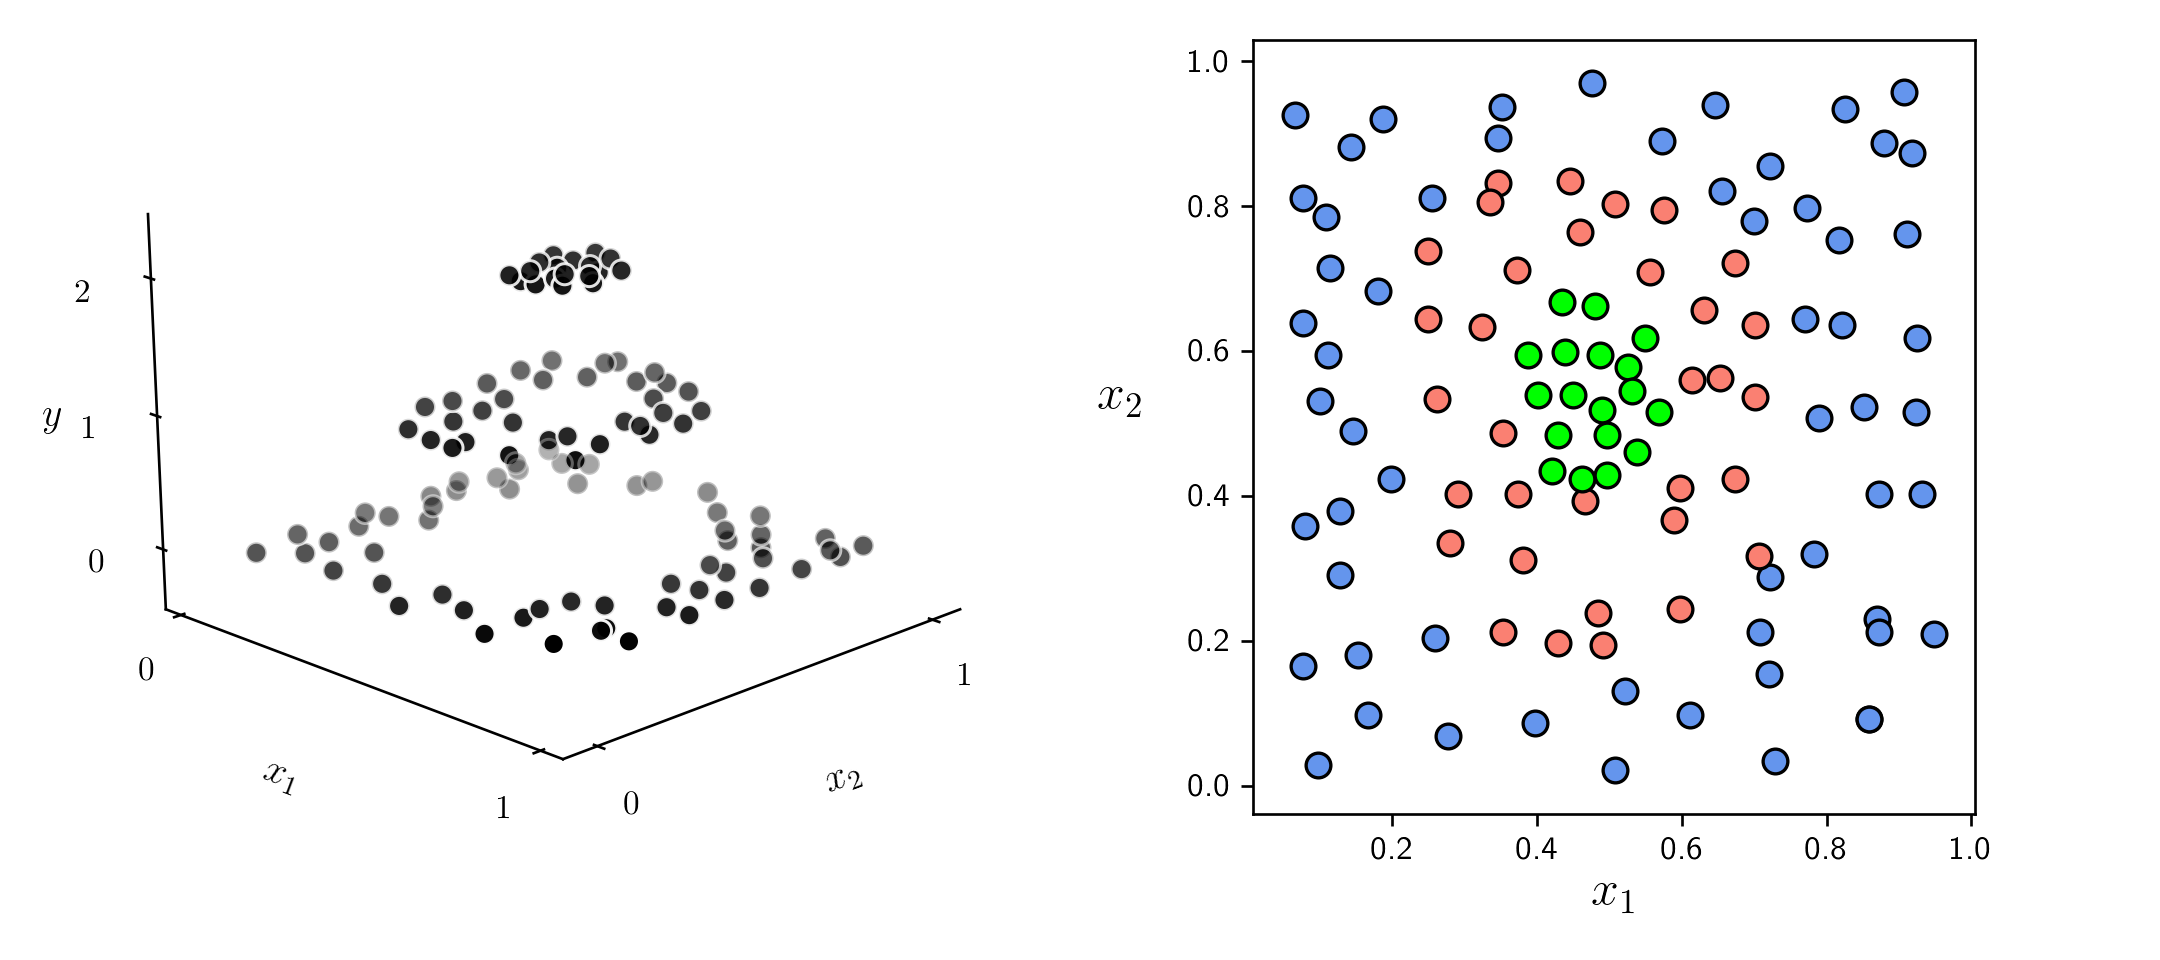

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# create instance of a multiclass classification visualizer
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '3_layercake_data.csv')
x = demo.x.T
y = demo.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data();

While it looks like the classes of this dataset can be cleanly separated via elliptical boundaries, the distribution of each class is not centered at the origin (as was the case in the previous example).  This means that, in order to properly determine these elliptical boundaries, we cannot just use pure quadratic terms in each input dimension (as was done in the previous example).  Here to capture this behavior we will use a full degree 2 polynomial expansion of the input.  Terms from a general degree $D$ polynomial always take the form

\begin{equation}
f\left(\mathbf{x}\right) = x_1^ix_2^j
\end{equation}

where $i + j \leq D$.  To employ all of them for $D = 2$ means using the following nonlinear model

\begin{equation}
\text{model}\left(\mathbf{x},\Omega\right) = w_0 + x_1w_1 + x_2w_2 + x_1x_2w_3 + x_1^2w_4 + x_2^2w_5
\end{equation}

where each term in usage (besides the bias $w_0$) is an unparameterized feature transformation.

After standard-normalzing the input, we solve each of the $C$ two class problems (via minimizing the Softmax cost) employing the feature transformation above using $1,500$ gradient descent steps, $\alpha = 1$ for each run, and the same random initialization for each run. Now we plot each resulting two-class classifier (top row below), as well as the combined results determined by the fusion rule both from a regression perspective (bottom left panel) and from 'above' (in the right panel).  Here we were able to achieve perfect classification.

<IPython.core.display.Javascript object>


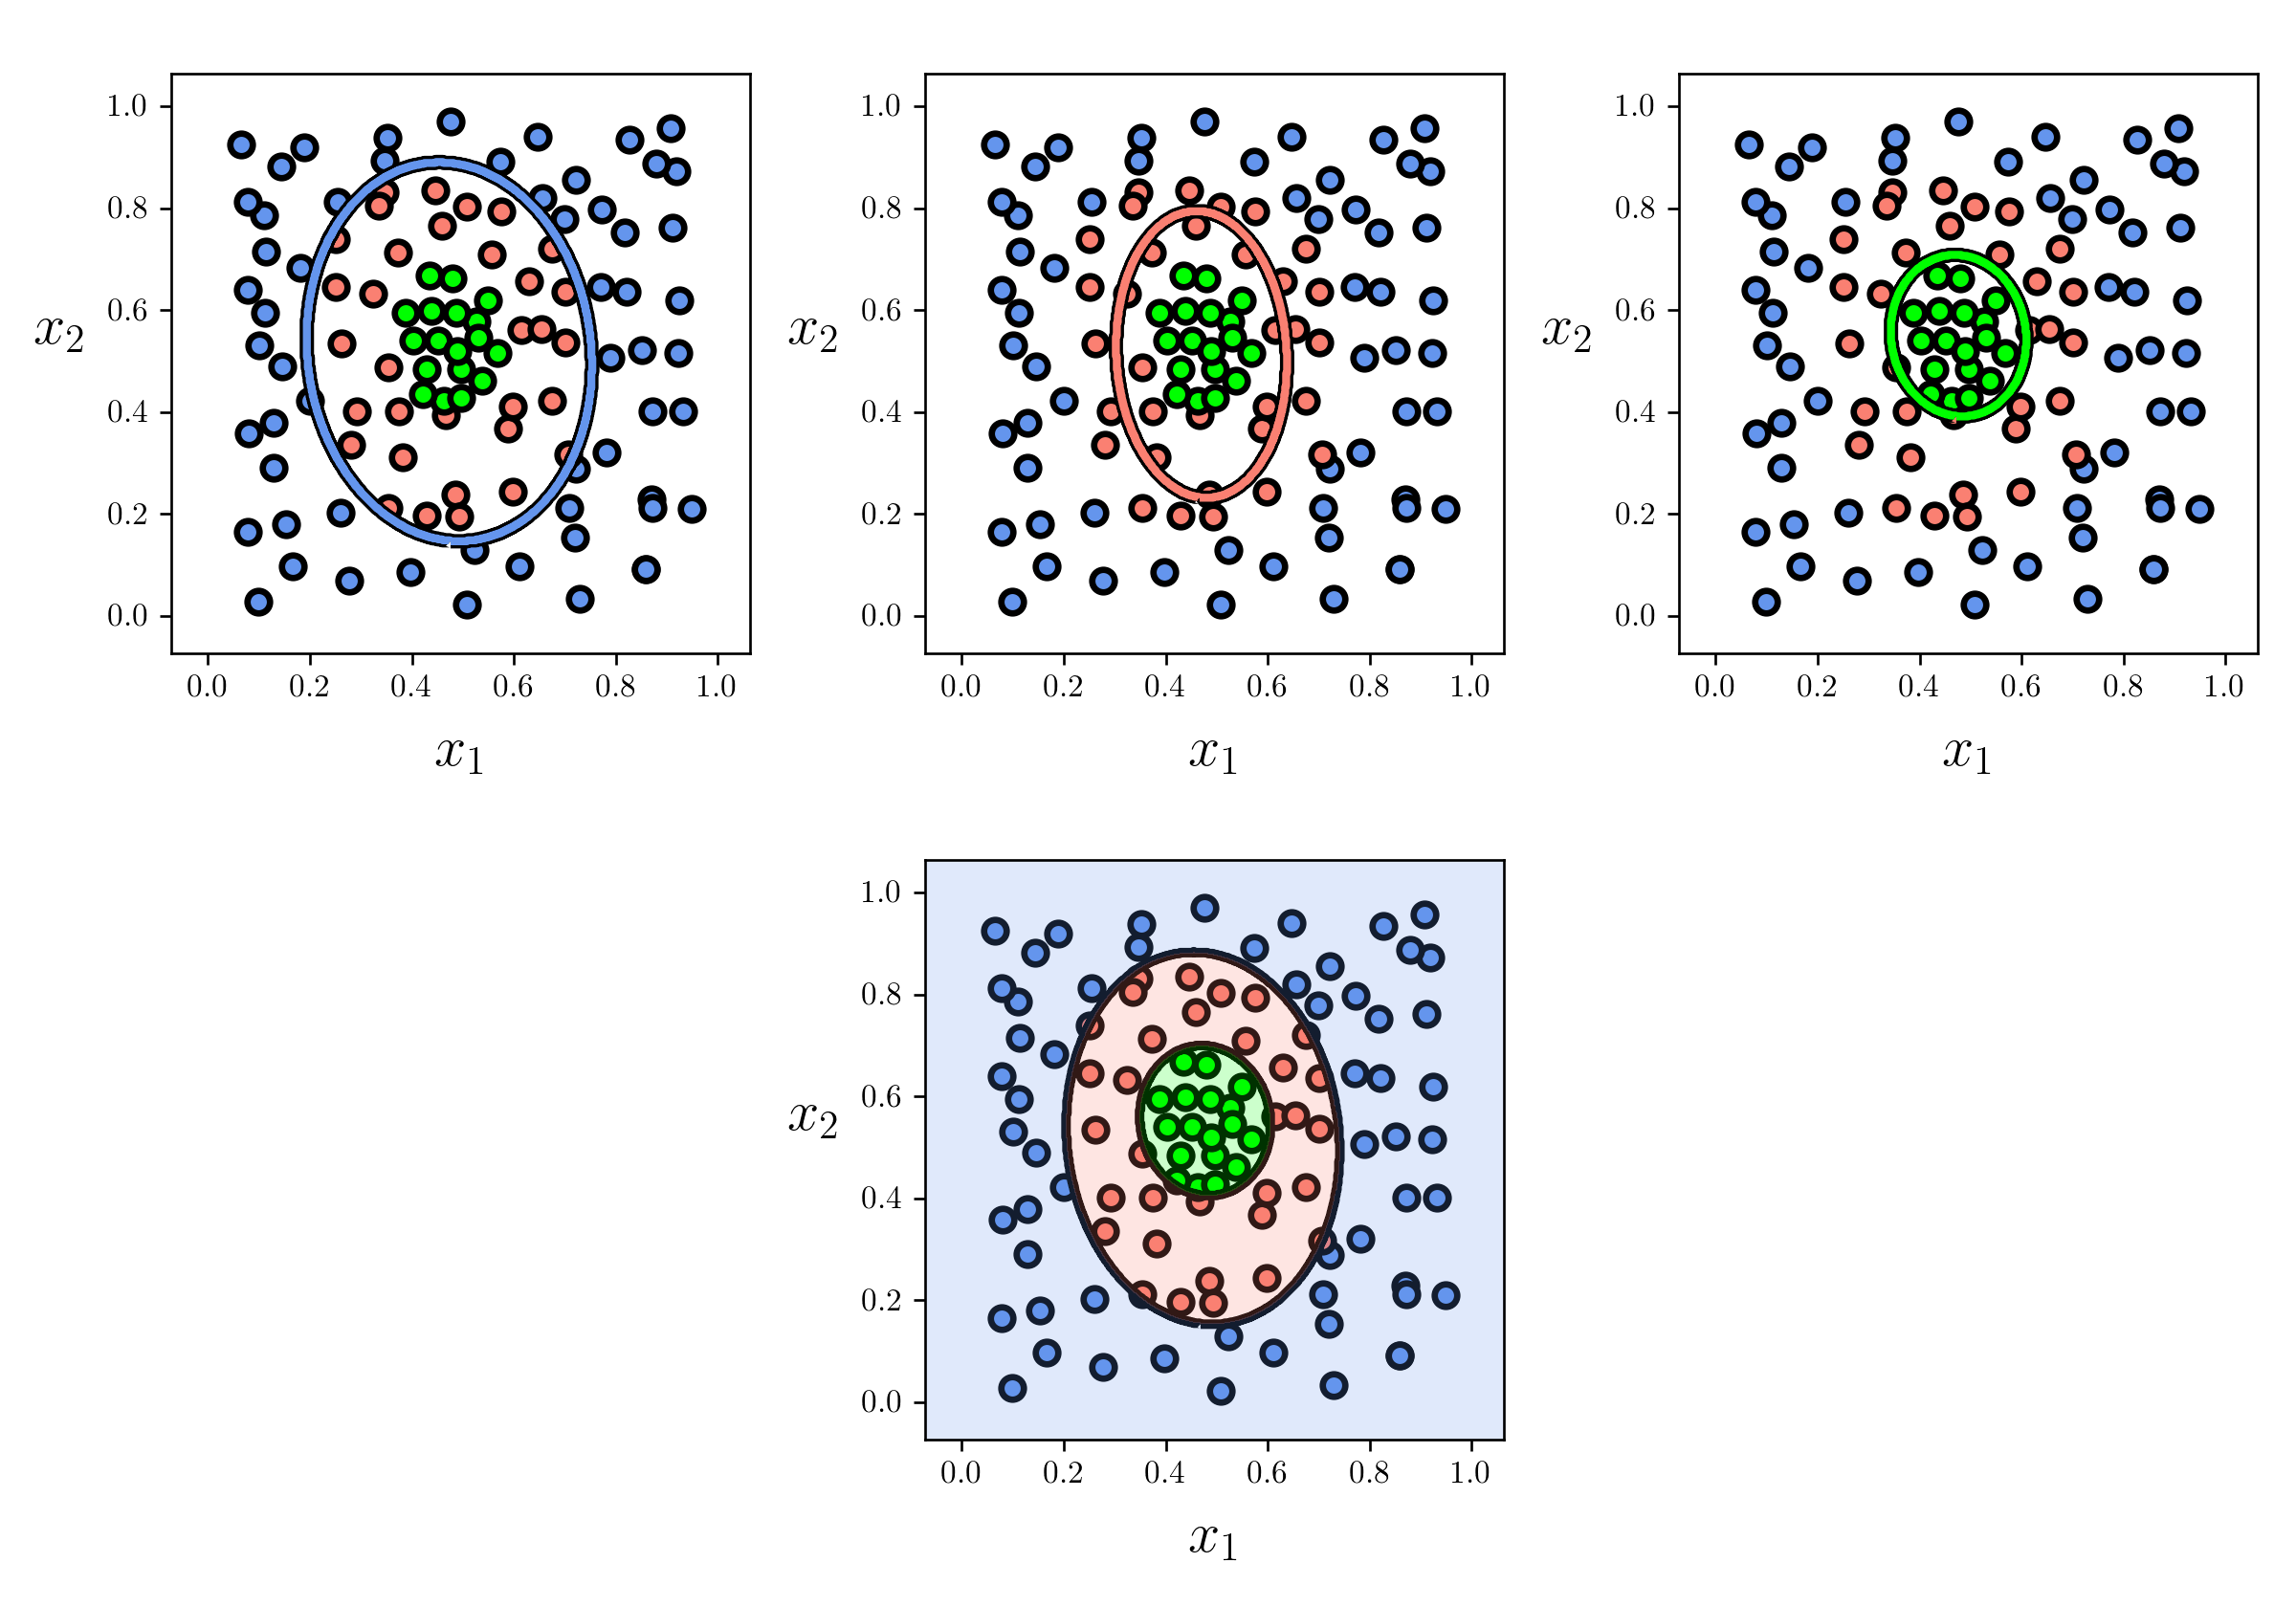

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# a elliptical feature transformation
def feature_transforms(x):
    # calculate feature transform
    f = []
    for i in range(0,D):
        for j in range(0,D-i):
            if i > 0 or j > 0:
                term = (x[0,:]**i)*((x[1,:])**j)
                f.append(term)
    return np.array(f)

# run one versus all
max_its = 1500; alpha_choice = 10**(0); w = 0.1*np.random.randn(6,1); D = 3;
combined_weights, count_history = nonlib.one_versus_all.train(x,y,feature_transforms,alpha_choice = alpha_choice,max_its = max_its,w = w)

# draw resulting nonlinear boundaries for each classification problem, as well as the
# entire multiclass boundary
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'multiclass_counter',normalize = 'standard')
w_best = combined_weights[-1]
demo.show_individual_classifiers(run,w_best)

## 10.4.3  Sharing nonlinear feature transformations for multi-class classification

With the latter approach to nonlinear multi-class classification we engineer a *single set of nonlinear feature transfomations and share them among all $C$ models* and tune all parameters simultaneously by minimizing an appropriate cost function (e.g., the Multiclass Perceptron or Softmax).  This means that we use *precisely the same functionalities* for all $C$ models of the form written above in equation (2), and can likewise express all $C$ models together in one formula as

\begin{equation}
\text{model}\left(\mathbf{x},\Omega\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{W}.
\end{equation}

Note here that the set $\Omega$ contains the linear combination weights $\mathbf{W}$ as well as any parameters internal to our feature transformations.  Also note here that *unlike* the case of multi-output regression even if these transforms contain *no* internal parameters, e.g., if they are polynomial functions, even though the *model* above decomposes over the *weights of the linear combination* as 

\begin{equation}
\mathring{\mathbf{f}}_{\,}^T \mathbf{W} = \sum_{c=0}^{C-1} \mathring{\mathbf{f}}_{\,}^T \mathbf{w}_c
\end{equation}

the corresponding multi-class cost functions *do not*.  We can see this by simply examining the Multiclass Softmax cost employing the general nonlinear model above

\begin{equation}
g\left(\Omega\right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{  \mathring{\mathbf{f}}_{\,}^T \mathbf{w}_c}  \right) -  \mathring{\mathbf{f}}_{\,}^T \mathbf{w}_{y_p}\right]
\end{equation}

where we can see that - since each summand contains weights from the entire matrix $\mathbf{W}$ of linear combination weights - it is impossible to disentangle the column weights $\mathbf{w}_c$.

Thus regardless of whether or not our feature transformations contain internal parameters, the only weights *unique* to each individual model are those contained in the linear combination.  In other words, with (nonlinear) multi-class classification if we choose to learn all $C$ models together - regardless of whether or not our feature transformations contain internal parameters - we must tune all of our model parameters *jointly*, that is learn all $C$ models *simultaneously* via minimization of an appropriate multi-class cost (like e.g., the Multiclass Perceptron or Softmax). As we will see sharing (especially parameterized) feature transformations makes the chore of nonlinear feature engineering - and especially the job of feature learning employing neural networks as we will see in Chapter 12 - considerably easier.

#### <span style="color:#a50e3e;">Example 2. </span>  Nonlinear multiclass softmax classification

Here we repeat the same experiment on the same dataset discussed in the previous example, as well as the same set of polynomial feature transformations, but now use the Multiclass Softmax cost function to perform classification simultaneously.  We tune all parameters of the model simultaneously via gradient descent and - as shown below - achieve just as solid results as when using the nonlinear One-versus-All framework.

<IPython.core.display.Javascript object>


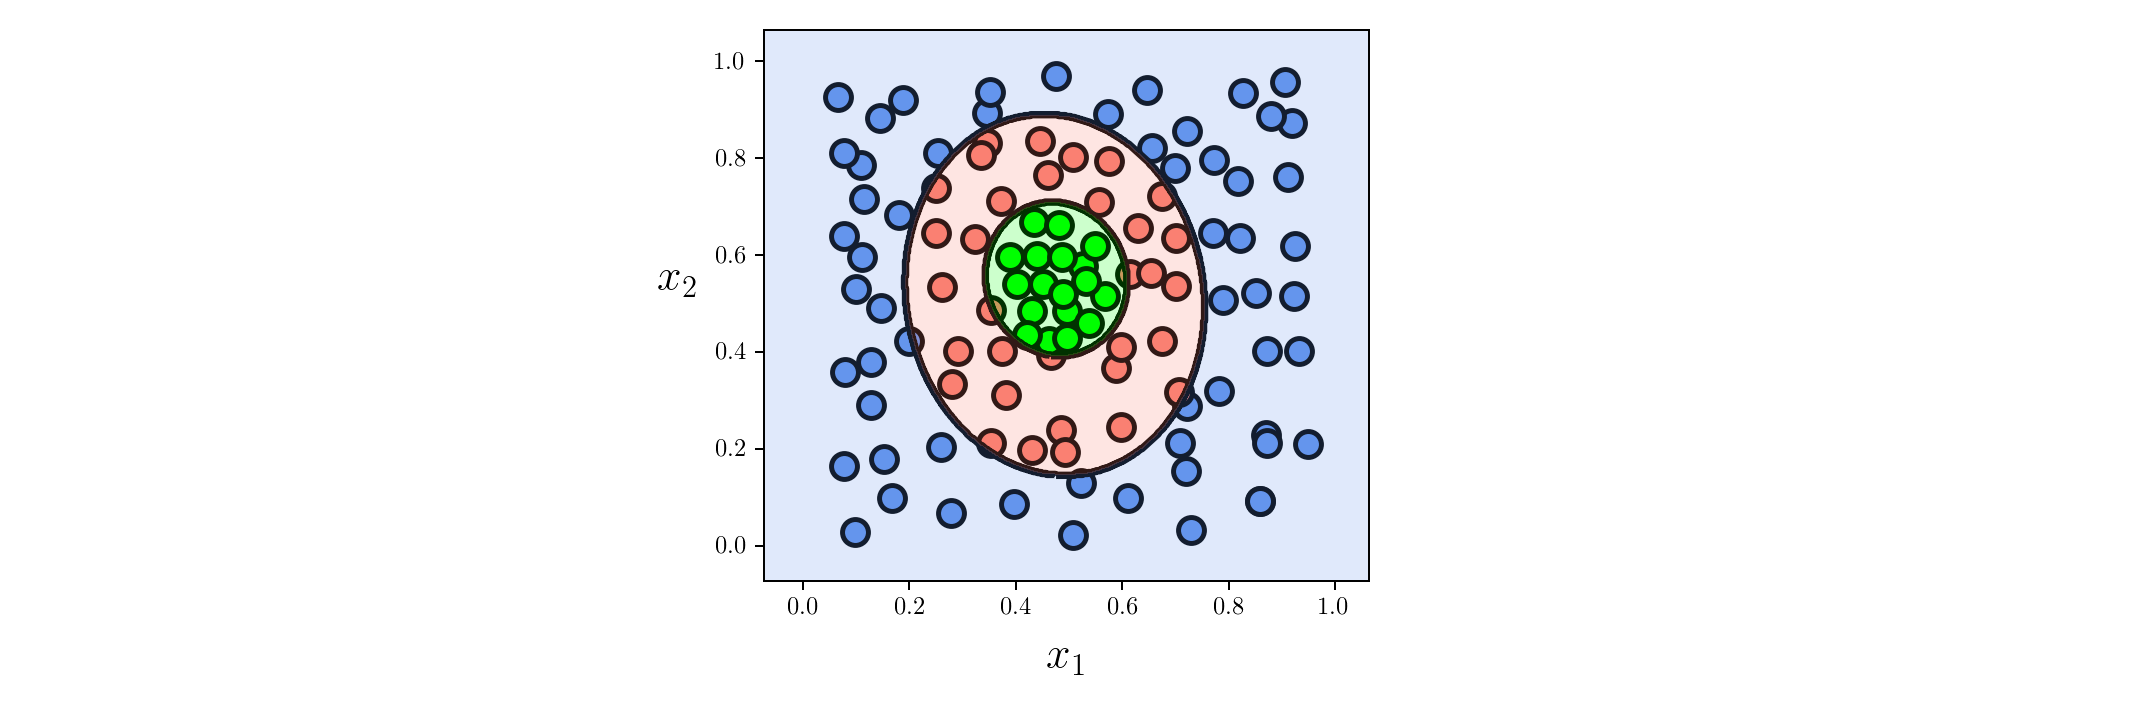

In [8]:
## This code cell will not be shown in the HTML version of this notebook
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(6,3); max_its = 1500; alpha_choice = 10**(0)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'multiclass_softmax',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

# plot result of nonlinear multiclass classification
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.multiclass_plot(run,w_best)

## 10.4.4 Implementing joint nonlinear multi-class classification in `Python`

The general nonlinear model in equation (7) above can be implemented precisely as described in Section 10.1.3. since - indeed - it is the same general nonlineaer model we use with nonlinear multi-output regression.  Therefore, just as with multi-output regression, the we need not alter the implementation of a joint nonlinear multi-class classification cost function introduced in Chapter 7 to perform  classification: all we need to do is properly define our nonlinear transformation(s) in `Python` (if we wish to use an automatic differentiator then these should be expressed using `autograd`'s `numpy` wrapper).  